# MIMIQ demo - Grover's Algorithm
QPerfect 2025 https://qperfect.io/

The interactive version of this demo can be found at https://github.com/qperfect-io/MimiqDemos/blob/main/Grover/grover.ipynb

## Introduction and context
Grover's algorithm is a foundational quantum algorithm that offers a quadratic speedup for unstructured search problems. Introduced by Lov Grover in 1996, it efficiently finds a specific item in an unsorted database of size $N$ using only $O(\sqrt{N})$ queries to the database, compared to the $O(N)$ queries required by classical algorithms. Grover's algorithm has broad applications, including in cryptography, optimization problems, pattern matching and machine learning and quantum complexity theory.

### Problem definition

The standard implementation of Grover's algorithm consists of the following steps:

1. Initialization: Start with a register of $n$ qubits in the $|0\rangle$ state, where $N = 2^n$ is the size of the search space

2. Superposition: Apply Hadamard gates (H) to all qubits, creating a uniform superposition of all possible states

3. Grover Iteration: Repeat the following steps $\sqrt{N}$ times:
   a. Oracle Operation: Apply the phase oracle that marks the target state by flipping its phase
   b. Diffusion Operator: Apply the Grover diffusion operator, which consists of:
      - Hadamard gates on all qubits
      - A conditional phase shift of -1 on all states except $|0\rangle$
      - Hadamard gates on all qubits again

4. Measurement: Measure the qubits in the computational basis to obtain the solution with high probability.

The number of iterations is typically chosen to be $\lfloor \pi/4 \cdot \sqrt{N} \rfloor$ which provides the optimal probability of finding the target state.

### MIMIQ Features used in this demo
- Multicontrol gates
- Circuit primitives: Diffusion, Polynomial Oracle
- Use of the z-register to store state amplitudes midcircuit 

## MIMIQ implementation
In this demo we will first implement a simple version of Grover's algorithm to identify desired bit string among $2^n$ possible bitstrings.

Let's start by importing the required packages, and connecting to the MIMIQ service

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from quantanium import *
from mimiqcircuits import *

# create a connection to the MIMIQ server
sim = Quantanium()

Next we can define Grover's algorithm. The following function takes the number of iterations and an oracle circuit as inputs and generates the full circuit for Grover's algorithm.

In [3]:
def grover(iterations, oracle_circ, callback=None):
    """
    MIMIQ circuit for Grover's algorithm.
    
    Args:
    iterations (int): Number of Grover iterations.
    oracle_circ (Circuit): Oracle circuit.
    
    Returns:
    Circuit: The Grover's algorithm quantum circuit.
    """
    nq = oracle_circ.num_qubits()
    circ = Circuit()
    
    # Create the uniform superposition state
    circ.push(GateH(), range(nq))
    
    for i in range(iterations):    
        # Callback for storing the amplitudes of
        # the target strings in the z register
        if callback:
            circ.append(callback(i))
            
        # Apply the oracle operator
        circ.append(oracle_circ)
        
        # Apply the diffusion operator
        circ.push(Diffusion(nq), *range(nq))    
    return circ

We'll also define a callback function for adding an `Amplitude` instruction to the circuit which will put the probability amplitude of the state corresponding to a given bitstring for each iteration in the z-register for plotting.

In [4]:
def amplitude_callback(bitstring):
    def callback(i):
        circ = Circuit()
        circ.push(Amplitude(bitstring), i)
        return circ
    return callback

Finally we need to define the oracle operator. As a simple example we consider a circuit which flips the phase of one or more desired bitstrings, which will serve as our target states. In MIMIQ a phase flip for a desired bitstring can be easily implemented using a multicontrolled-Z gate

In [5]:
def oracle(bitstring):
    """
    Create an oracle circuit that flips the phase of a desired bitstring.
    
    Args:
    bitstring: Target bitstring to mark.
    
    Returns:
    Circuit: Oracle circuit that marks the target state.
    """
    nq = len(bitstring)
    circ = Circuit()

    # Apply X gates where bits are 0
    for i, b in enumerate(bitstring):
        if not b:
            circ.push(GateX(), i)

    # Multi-controlled Z gate
    circ.push(control(nq-1, GateZ()), *range(nq))

    # Uncompute X gates
    for i, b in enumerate(bitstring):
        if not b:
            circ.push(GateX(),i)
            
    return circ

Now we are ready to test the algorithm on MIMIQ. Here we specify a simple target bitstring and generate the circuit with callback function. This allows to obtain the relevant state amplitude in each iteration with one execution.

In [6]:
# define parameters
targetstr = BitString([1,0,1,0,1,0,1,0])
maxiter=12
n = len(targetstr)

# generate circuits and execute
circuit = grover(maxiter, oracle(targetstr), callback=amplitude_callback(targetstr))

results = sim.execute(circuit, bitstrings=[targetstr])

In [7]:
results

QCSResults:
├── simulator: Quantanium StateVector 1.0
├── timings:
│    ├── apply time: 0.000267566s
│    └── sample time: 0.000122923s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    └── bs"10101010" => 1000
├── zreg (most sampled):
│    └── [(0.06249999999999996+0j), (-0.18652343749999986+0j), (0.3076324462890622+0j), (-0.423934698104858+0j), (0.5336129702627652+0j), (-0.6349535397603168+0j), (0.7263729601991133+0j), (-0.8064428031347988+0j), (0.8739119772715029+0j), (-0.9277262767633397+0j), (0.9670448531807495+0j), (-0.9912533537672099+0j)] => 1
├── 1 executions
├── 1 amplitudes
└── 1000 samples

We can then plot the probability of the final state in the target bitstring as a function of the number of iterations, which will show a characteristic oscillatory behavior.

Grover search algorithm: target strings 8-qubit BitString with 4 non-zero qubits:
├── |10101010⟩
└── non-zero qubits: [0, 2, 4, 6]


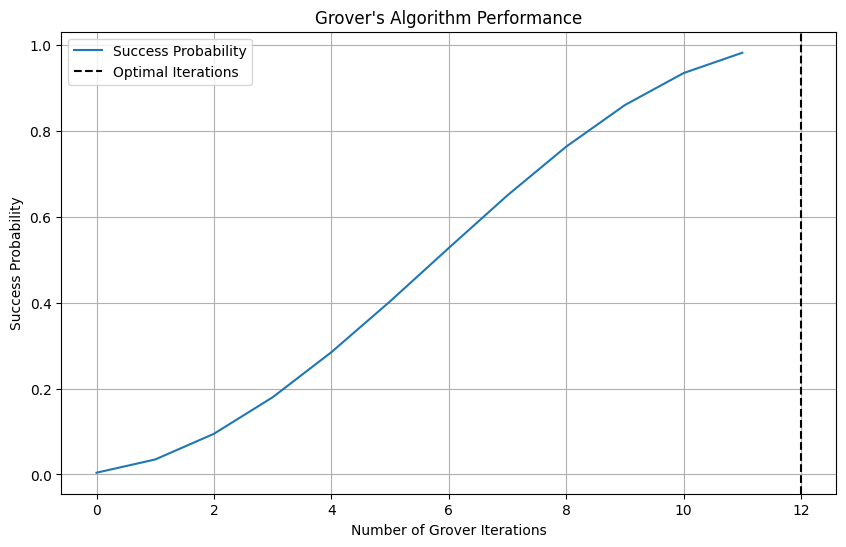

In [8]:
# Calculate success probabilities
success_probs = [abs(a)**2 for a in results.zstates[0]]

# estimate the optimal number of iterations
iterations = int(np.floor(np.pi/4*np.sqrt(2**n)))

# display results
print(f"Grover search algorithm: target strings {targetstr}")
plt.figure(figsize=(10, 6))
plt.plot(success_probs, label='Success Probability')
plt.axvline(x=iterations, color='k', linestyle='--', label='Optimal Iterations')
plt.xlabel('Number of Grover Iterations')
plt.ylabel('Success Probability')
plt.title("Grover's Algorithm Performance")
plt.legend()
plt.grid(True)
plt.show()

We see that the success probability reaches very close to 1 after the expected number of iterations (12 in this case)

## Going further with MIMIQ

The oracle in Grover's algorithm is often a source of confusion, particularly since in the preceeding example it seems that the Oracle already contains the solution. However that is not necessary. The oracle in Grover's algorithm serves as a black box that can identify the correct state without revealing it directly. To demonstrate this, we will implement a more advanced oracle which can be used to factor composite integers.

### Explanation of the factoring algorithm

**For a given integer $N$ we aim to find its factors $p$, $q$ which satisfy $N=pq$.**

We can formulate the factoring problem as a search problem in which we aim to find the factors $p$,$q$ which satisfy 

$$|N - pq| = 0$$

To solve this problem using quantum circuits, we can define three quantum registers $X, Y, Z$ with $n_x, n_y$ and $n_z = n_x + n_y + 1$ qubits respectively. 


The algorithm starts with the $X$ and $Y$ registers initialized in the uniform state. The $Z$ register is initialized in the state $|N\rangle$ where $N$ is the binary representation of the number to be factored. 

This is followed by a loop with $K$ steps, where in each step an Oracle operator is applied to marks the solution state and the diffusion operator from Grover's algorithm is applied to increase the amplitude in the solution state. 

The Oracle can be constructed in three steps:
- $|x,y\rangle|z=N\rangle \rightarrow |x,y\rangle|z=N-xy\rangle$ inverse multiplication
- $|z=0\rangle \rightarrow -|z=0\rangle$ inverted multicontrol Z gate
- $|x,y\rangle|z=N-xy\rangle \rightarrow |x,y\rangle|z=N\rangle$ multiplication

i.e., the state where $N=xy$ will acquire a $\pi$ phase shift while all other states will remain unaffected. 

After $K = \lfloor \frac{\pi}{4}2^{(n_x+n_y)/2} \rfloor$ steps the algorithm converges and the solution can be directly read out by measuring the $X$ and $Y$ registers in the computational basis.

### Circuit primitives

In [9]:
def PhiMultiply(X, Y, Z):
    """
    Acts on three registers to perform the transformation 
    |x,y,z> -> |x,y,z+x*y> in Fourier space
    """
    circ = Circuit()
    nx, ny, nz = len(X), len(Y), len(Z)
    
    # multiplication x*y 
    for j in range(nx):
        for i in range(ny):
            for k in range(i+j, nz):
                angle = 2*np.pi / 2.0**(k - j - i + 1)
                if angle % (2*np.pi) != 0:  # do nothing if angle is multiple of 2pi
                    ctr1, ctr2, target = X[j], Y[i], Z[k]
                    circ.push(Control(2,GateP(angle)), ctr1, ctr2, target)
    return circ

def Multiply(X, Y, Z):
    """
    Performs the operation |x,y,z> -> |x,y,z+xy>
    """
    circ = Circuit()
    nx, ny, nz = len(X), len(Y), len(Z)

    circ.push(QFT(nz), *Z)
    circ.append(PhiMultiply(X, Y, Z))
    circ.push(inverse(QFT(nz)), *Z)
    
    return circ

### Factorizing circuit
Next, we construct the quantum circuit that implements Grover's algorithm for factorization. The circuit includes $K$ Grover iterations, each consisting of the multiplication operator oracle followed by the diffusion operator acting on the X and Y registers. To capture the result, we apply a single Measure instruction to the qubits in the X register. The outcome of this measurement will provide us with the information needed to determine the factors of our input number.

In [10]:
def factorize(N: int, K: int, nx: int, ny: int):
    # prepare registers
    nz = nx + ny + 1
    X = list(range(0, nx))
    Y = list(range(nx, nx + ny))
    Z = list(range(nx + ny, nx + ny + nz))
    
    Nj = [int(b) for b in bin(N)[2:][::-1]]  # binary digits of N, least significant first

    # initialize
    circ = Circuit()
    
    circ.push(GateH(), X + Y)
    for j, b in enumerate(Nj):
        if b == 1:
            circ.push(GateX(), Z[j])
    
    # Grover loop
    for k in range(K):
        # Oracle
        #circ.push(PolynomialOracle(nx+ny, nz, 1,0,0,0), *(X+Y+Z))
        circ.append(inverse(Multiply(X, Y, Z)))
        circ.push(GateX(), Z)
        circ.push(Control(nz-1, GateZ()), *Z)
        circ.push(GateX(), Z)
        circ.append(Multiply(X, Y, Z))

        # Diffusion
        circ.push(Diffusion(nx+ny), *(X+Y))
        
    circ.push(Measure(),X,X)
    return circ

### Create and run the circuit on the MIMIQ server and sample the outputs

In [11]:
N = 143 # 13 * 11
nx, ny = 4,4
iterations = 8
circuit = factorize(N, iterations, nx, ny)
# Submit the job
res = sim.execute(circuit)

## Extract the output bitstrings and integer values

In [12]:
#Get the histogram of measurement results
histogram = res.histogram()

# Convert binary strings to integers and create a sorted list of results
sorted_results = sorted([int(bitarray.to01(), 2) for bitarray in histogram.keys()])

# Print the results in a more readable format
print("Measurement results:")
print(f"{'Bitstring':<10} {'Decimal':<10} {'Occurrences':<12} {'Probability':<12}")
print("-" * 50)
for outcome, shots in histogram.items():
    bitstring = outcome.to01()
    decimal = BitString(outcome).tointeger()
    probability = shots / len(res.cstates)
    print(f"{bitstring:<10} {decimal:<10} {shots:<12} {probability:.4f}")

print(f"\nTotal shots: {len(res.cstates)}")

Measurement results:
Bitstring  Decimal    Occurrences  Probability 
--------------------------------------------------
1011       13         506          0.5060
1101       11         489          0.4890
1001       9          1            0.0010
1100       3          1            0.0010
1000       1          1            0.0010
1010       5          1            0.0010
1110       7          1            0.0010

Total shots: 1000


The results of our quantum factorization simulation are remarkably successful. The X register consistently returns two outcomes, each occurring with approximately equal probability:

    1011 in binary, which is equivalent to 13 in decimal
    1101 in binary, which is equivalent to 11 in decimal

These outcomes are precisely the correct factors of our target number, as 13 * 11 = 143.

While Grover's algorithm doesn't offer the superpolynomial speedup that Shor's factoring algorithm can achieve, it effectively demonstrates how quantum algorithms can be applied to significant optimization and search problems.

We encourage you to experiment with different values of $N$, adjusting the size of the solution registers accordingly. For a deeper dive into this topic, we recommend the publication available at https://arxiv.org/abs/2312.10054. This paper details a variant of this algorithm that successfully factored numbers as large as 30,398,263,859 (7393 × 4,111,763) using MIMIQ!